# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [13]:
import math

def color_selection(img, lower_threshold, upper_threshold):
    """Finds the white and yellow colors in the given image"""
    return cv2.inRange(img, lower_threshold, upper_threshold)

def get_white_yellow_mask_RGB(image):
    """Get the white and yellow mask based on the RGB color space"""
    lt_yellow = np.uint8([190,190,0])
    lt_white = np.uint8([200,200,200])
    ut = np.uint8([255,255,255])
    yellow_mask = color_selection(image, lt_yellow, ut)
    white_mask = color_selection(image, lt_white, ut)
    return cv2.bitwise_and(image, image, mask = cv2.bitwise_or(yellow_mask, white_mask))

def get_white_yellow_mask_HLS(image):
    """Get the white and yellow mask based on the HLS color space"""
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lt_yellow = np.uint8([0,0,100])
    lt_white = np.uint8([0,200,0])
    ut = np.uint8([255,255,255])    
    yellow_mask = color_selection(hls, lt_yellow, ut)
    white_mask = color_selection(hls, lt_white, ut)
    return cv2.bitwise_and(image, image, mask = cv2.bitwise_or(yellow_mask, white_mask))

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def auto_canny(image, sigma=0.33):
    """Applies canny transform by calculating lower and upper threshold by 
    calculating median and taking default sigma=0.33"""
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(image, lower, upper)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(actual_img, lines, avgPolyFit, color=[255, 0, 0], thickness=12):
    """This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    img = np.zeros((actual_img.shape[0], actual_img.shape[1], 3), dtype=np.uint8)
    
    leftX = []
    leftY = []
    rightX = []
    rightY = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0.5: #left
                leftX += [x1, x2]
                leftY += [y1, y2]
            elif slope > 0.5: #right
                rightX += [x1, x2]
                rightY += [y1, y2]
    
    topY = int(img.shape[0]*0.65)
    bottomY = img.shape[0]
    
    #left region
    if len(leftY):    
        leftPolyFit = np.polyfit(leftY, leftX, 1)
        avgPolyFit.addLeft(leftPolyFit)
        #print("actual lpf: ",leftPolyFit)
    
    lpf = avgPolyFit.getAvgLeft()
    leftZ = np.poly1d(lpf)
    leftLine = np.array([
        (int(leftZ(bottomY)), bottomY),
        (int(leftZ(topY)), topY)
    ], dtype = np.int32)
    #print("Left - avgpf: ", lpf)
    #draw left line
    cv2.line(img, tuple(leftLine[0]), tuple(leftLine[1]), color, thickness)
    
    #right region
    if len(rightY):
        rightPolyFit = np.polyfit(rightY, rightX, 1)
        avgPolyFit.addRight(rightPolyFit)
        #print("actualpf: ", rightPolyFit)
    
    rpf = avgPolyFit.getAvgRight()
    rightZ = np.poly1d(rpf)
    rightLine = np.array([
        (int(rightZ(topY)), topY),
        (int(rightZ(bottomY)), bottomY)
    ], dtype = np.int32)
    #print("Right - avgpf: ", rpf)
    #draw right line
    cv2.line(img, tuple(rightLine[0]), tuple(rightLine[1]), color, thickness)
    
    # fill region with green color
    points = np.concatenate((leftLine, rightLine), axis=0)
    #print("points for fillpoly: ", points)
    fillRegion(img, [points], [0,255,0])
    return img

def fillRegion(image, vertices, color = [0,255,0]):
    """this function fills the region with given vertices and color on the given image inplace"""
    #print("points for fillpoly: ", points)
    cv2.fillPoly(image, vertices, color)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def save_image(file_path, image, isRGB = 1):
    """save image with given file path"""
    if isRGB:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(file_path, image )

## Classes to calculate average poly fit
### Mean
This class is used to calculate the Average of given items

In [3]:
class Average:
    """store list by adding to item and return Average"""

    def __init__(self, period):
        self.total = 0
        self.queue = []
        self.period = period
    
    def append(self, item):
        """add item to the list"""
        #print("append item: ", item)
        self.total += item
        self.queue.append(item)
        #print("append total new ", self.total)
        if len(self.queue) > self.period:
            self.total -= self.queue.pop(0)
        
    def getAverage(self):
        """get the mean of the list"""
        length = len(self.queue)
        if length == 0:
            length = 1
        #print("get avg, total: ", self.total, ", queue length: ", len(self.queue), "mean: ", self.total/length)
        return self.total/length
    
    def clear(self):
        """clear the average"""
        self.total = 0
        self.queue.clear()
        
class AveragePolyFit:
    """calculate and store the average PolyFit for left and right poly fit"""
    
    def __init__(self, period):
        self.left = Average(period)
        self.right = Average(period)
        
    def clear(self):
        """clear all averages"""
        self.left.clear()
        self.right.clear()
    
    def addLeft(self, item):
        """add the left polyFit"""
        self.left.append(item)
    
    def getAvgLeft(self):
        """get the average left poly fit"""
        return self.left.getAverage()
    
    def addRight(self, item):
        """add the right polyFit"""
        self.right.append(item)
    
    def getAvgRight(self):
        """get the average right poly fit"""
        return self.right.getAverage()


# Lane finding pipeline
Pipeline which uses all helper functions to identify the plot the lane lines

In [4]:
def process_image(img):
    """process the given image and find edges and plot lines on the lane lines"""
    copy = np.copy(img)
    
    #region for masking
    vertices = np.array([
        [copy.shape[1]*0.05, copy.shape[0]*1.0],
        [copy.shape[1]*0.45, copy.shape[0]*0.6],
        [copy.shape[1]*0.55, copy.shape[0]*0.6],
        [copy.shape[1]*0.98, copy.shape[0]*1.0]
    ], dtype=np.int32)
    copy = get_white_yellow_mask_HLS(copy)
    copy = grayscale(copy)
    copy = gaussian_blur(copy, 11)
    copy = canny(copy, 70, 210)
    copy = region_of_interest(copy, np.array([vertices]))

    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_len = 20
    max_line_gap = 200

    lines = hough_lines(copy, rho, theta, threshold, min_line_len, max_line_gap)
    global avgPF
    copy = draw_lines(copy, lines, avgPF)
    copy = weighted_img(copy, img, 1, .2, 0.09)
    return copy

## Testing the algorithm on given images
The given pipeline takes input directory and output directory paths as parameters and processes all image files in the input directory and stores the output images in the output directory

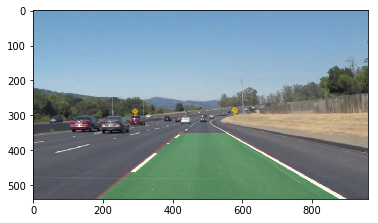

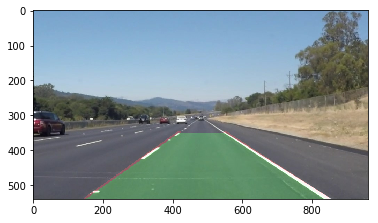

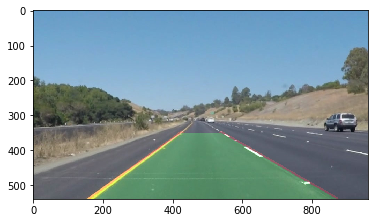

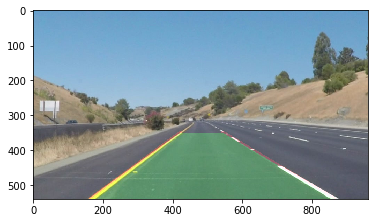

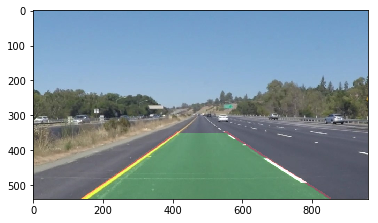

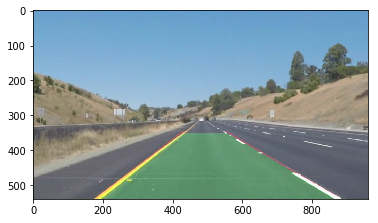

In [14]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def process_save_images(inputDir, outputDir):
    import os
    if not os.path.exists(os.path.dirname(outputDir)):
        try:
            os.makedirs(os.path.dirname(outputDir))
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise
    avgPF = AveragePolyFit(10)
    #plt.figure(figsize=(20,10))
    for f in os.listdir(inputDir):
        #print("writing to:" , outputDir  + f)
        image = mpimg.imread(inputDir + f)
        global avgPF
        avgPF.clear()
        oput = process_image(image)
        plt.figure()
        plt.imshow(oput)
        save_image(outputDir + f, oput)
        
process_save_images("test_images/", "test_images_output/")
#process_save_images("challenge/", "challenge_output/")

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [15]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
avgPF = AveragePolyFit(20)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 26.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 10.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
avgPF = AveragePolyFit(20)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:29<00:00, 26.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 31.5 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
avgPF = AveragePolyFit(20)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:22<00:00, 11.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 26 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))